<a href="https://colab.research.google.com/github/tuanyuan2008/cs4641/blob/master/randomized-optimization/N_queens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install mlrose

import mlrose
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
import timeit

$N$-Queens Problem
=============

The following is a custom fitness function that represents pairs of non-attacking queens. For $n$ queens, we have max fitness = $\binom{n}{2}$.

In [0]:
# Define alternative N-Queens fitness function for maximization problem
def queens_max(state):
    
    # Initialize counter
    fitness = 0
    
    # For all pairs of queens
    for i in range(len(state) - 1):
        for j in range(i + 1, len(state)):
            
            # Check for horizontal, diagonal-up and diagonal-down attacks
            if (state[j] != state[i]) \
                and (state[j] != state[i] + (j - i)) \
                and (state[j] != state[i] - (j - i)):
                
                # If no attacks, then increment counter
                fitness += 1

    return fitness

Simulated Annealing
----------

The $N-$Queens problem is an example of a discrete-state optimization problem, since each of the elements of the state vector must take on an integer value in the range $0$ to $N-1$. To tune parameters, let's start with the standard $8\times8$ checkerboard. The maximum fitness in this case is $\binom{8}{2}=28$.

In [0]:
  fitness_cust = mlrose.CustomFitness(queens_max)
  problem = mlrose.DiscreteOpt(length = 8, fitness_fn = fitness_cust,
                           maximize = True, max_val = 8)

A schedule object specifies how the simulated annealing temperature parameter changes over time.

In [0]:
  # Define decay schedules
  schedule = mlrose.GeomDecay()

In [0]:
  # Define initial state
  init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

  # Set random seed
  np.random.seed(1)

Let's initialize $\texttt{max_attempts}$, the number of attempts the algorithm should make to find a “better” state at each step, to $10$, and $\texttt{max_iters}$, the maximum number of iterations the algorithm should run for overall, to $100$. We'll tune these parameters later.

In [8]:
dic = {}

def tune_schedule(schedule):
  fit_scores = []

  for i in range(50):
    best_state, best_fitness = mlrose.simulated_annealing(problem, schedule = schedule,
                                                          max_attempts = 10, max_iters = 1000,
                                                          init_state = init_state)
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores.append(best_fitness)

  print('The average fitness is '+ str(sum(fit_scores) / 50) + ' for ' + str(schedule) + '.')
  
  return sum(fit_scores) / 50

dic[schedule] = tune_schedule(schedule)

The average fitness is 25.3 for <mlrose.decay.ArithDecay object at 0x7f6523da8898>.


We can see if using an exponential decay schedule or an arithmetic decay schedule produces better results.

<!-- With the geometric decay schedule, we obtained a fitness score of $27/28$, meaning there exists only one pair of two queens that are attacking each other. Upon further examination, we notice that this attack occurs on row $5$. -->

In [9]:
schedule = mlrose.ExpDecay()
dic[schedule] = tune_schedule(schedule) 

schedule = mlrose.ArithDecay()
dic[schedule] = tune_schedule(schedule) 

The average fitness is 25.92 for <mlrose.decay.ExpDecay object at 0x7f6523db1dd8>.
The average fitness is 25.32 for <mlrose.decay.ArithDecay object at 0x7f6523db1e48>.


It seems that each of the three schedules produces a similar fitness score.
<!-- , with the geometric decay schedule achieving a marginally higher score.  -->
Now, let's tune for the $\texttt{max_attempts}$ parameter.

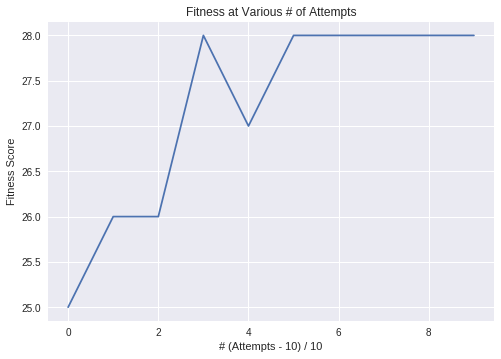

The maximum fitness score of 28.0 is obtained in 40 attempts.


In [11]:
SA_best_schedule = max(dic, key=lambda key: dic[key])

attempts = range(10, 110, 10)

best_score = 0
best_score_index = -1

fit_scores = [0] * len(attempts)

for i, a in enumerate(attempts):
  best_state, best_fitness = mlrose.simulated_annealing(problem, schedule = SA_best_schedule,
                                                        max_attempts = a, max_iters = 1000,
                                                        init_state = init_state)
#   print('Iteration ', str(i))
#   print('The best state found is: ', best_state)
#   print('The fitness at the best state is: ', best_fitness)
#   print('\n')

  fit_scores[i] = best_fitness

  if best_fitness > best_score:
    best_score = best_fitness
    best_score_index = (i + 1) * 10

plt.plot(fit_scores)

plt.title("Fitness at Various # of Attempts")
plt.xlabel("# (Attempts - 10) / 10")
plt.ylabel("Fitness Score")
plt.show()

print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' attempts.')

Using these values for our parameters, we can now observe the effect that modifying  $\texttt{max_iter}$ has on our fitness score.

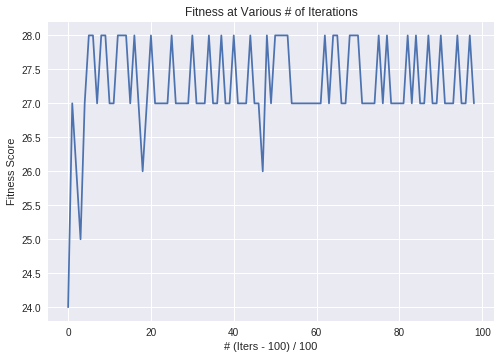

The maximum fitness score of 28.0 is obtained in 600 iterations.


In [12]:
SA_best_attempt = best_score_index

iters = range(100, 10000, 100)

def SA_iters(iters, best_schedule, best_attempt):
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(iters)

  for i, a in enumerate(iters):
    best_state, best_fitness = mlrose.simulated_annealing(problem, schedule = best_schedule,
                                                          max_attempts = best_attempt, max_iters = a,
                                                          init_state = init_state)
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 100

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Iterations")
  plt.xlabel("# (Iters - 100) / 100")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' iterations.')
  
  return best_score_index, fit_scores

SA_results = SA_iters(iters, SA_best_schedule, SA_best_attempt)

SA_best_iter = SA_results[0]
  
SA_fit_scores = SA_results[1]

Now, as we've been working with only $8$ queens, let's see how well this search technique generalizes for the $N$-Queens problem. We'll test values of $N$ up to $24$ queens.

N:  8
The best state found is:  [3 1 6 2 5 7 0 4]
The fitness at the best state is:  28.0
The maximum fitness is:  28
The number of attacking queens is:  0


N:  9
The best state found is:  [6 0 5 7 1 3 8 2 4]
The fitness at the best state is:  36.0
The maximum fitness is:  36
The number of attacking queens is:  0


N:  10
The best state found is:  [4 6 9 3 1 8 2 5 7 0]
The fitness at the best state is:  45.0
The maximum fitness is:  45
The number of attacking queens is:  0


N:  11
The best state found is:  [ 6  9  5  0  8  4  7  1  3  2 10]
The fitness at the best state is:  54.0
The maximum fitness is:  55
The number of attacking queens is:  1


N:  12
The best state found is:  [ 2  0  9  7  0 11  3 10  6  4  5  1]
The fitness at the best state is:  64.0
The maximum fitness is:  66
The number of attacking queens is:  2


N:  13
The best state found is:  [ 6 12 10  4  0  5  9  1  3 11  7  3 10]
The fitness at the best state is:  76.0
The maximum fitness is:  78
The number of attackin

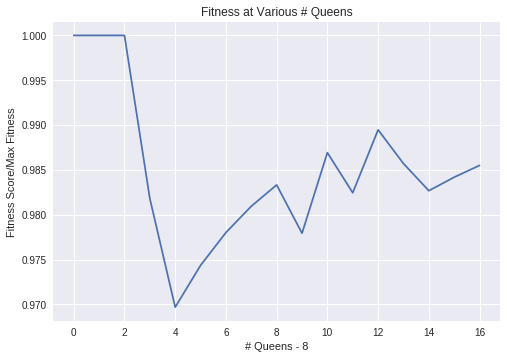

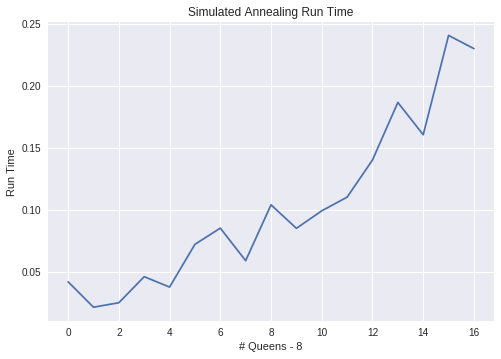

In [13]:
acc_SA_fit_scores = []
SA_times = []

for i in range(8, 25):
  problem = mlrose.DiscreteOpt(length = i, fitness_fn = fitness_cust,
                           maximize = True, max_val = i)
  
  # Define initial state
  init_state = np.array(np.arange(i))

  # Set random seed
  np.random.seed(i)
  
  start_time = timeit.default_timer()
    
  best_state, best_fitness = mlrose.simulated_annealing(problem, schedule = SA_best_schedule,
                                                        max_attempts = SA_best_attempt, max_iters = SA_best_iter,
                                                        init_state = init_state) 
  
  end_time = timeit.default_timer()
  training_time = end_time - start_time
  SA_times.append(training_time)
    
  print('N: ', str(i))
  print('The best state found is: ', best_state)
  print('The fitness at the best state is: ', best_fitness)
  print('The maximum fitness is: ', comb(i, 2, exact=True))
  print('The number of attacking queens is: ', int(comb(i, 2, exact=True) - best_fitness))
  print('\n')
  
  acc_SA_fit_scores.append(best_fitness / comb(i, 2, exact=True))

  
plt.plot(acc_SA_fit_scores)

plt.title("Fitness at Various # Queens")
plt.xlabel("# Queens - 8")
plt.ylabel("Fitness Score/Max Fitness")
plt.show()

plt.plot(SA_times)

plt.title("Simulated Annealing Run Time")
plt.xlabel("# Queens - 8")
plt.ylabel("Run Time")
plt.show()

Genetic Algorithms
----------



This time, suppose we wish to use a genetic algorithm with the default parameter settings of a population size ($\texttt{pop_size}$) of $200$, a mutation probability ($\texttt{mutation_prob}$) of $0.1$, a maximum of $10$ attempts per step ($\texttt{max_attempts}$) and no limit on the maximum total number of iteration of the algorithm ($\texttt{max_iters}$).

In [0]:
problem = mlrose.DiscreteOpt(length = 8, fitness_fn = fitness_cust,
                         maximize = True, max_val = 8)

Let's tune the population parameter.

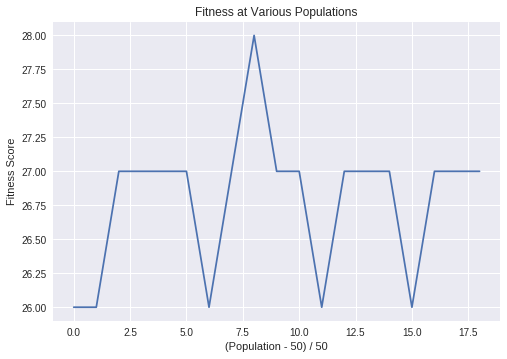

The maximum fitness score of 28.0 is obtained with population 450.


In [29]:
pop = range(50, 1000, 50)

def tune_pop(pop):
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(pop)

  for i, a in enumerate(pop):
    best_state, best_fitness = mlrose.genetic_alg(problem, pop_size=a, mutation_prob=0.1, max_attempts=10, max_iters=np.inf)
    
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 50

  plt.plot(fit_scores)

  plt.title("Fitness at Various Populations")
  plt.xlabel("(Population - 50) / 50")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained with population ' + str(best_score_index) + '.')
  
  return best_score_index

optimal_pop = tune_pop(pop)

And we'll tune the mutation probability and maximum number of attempts in a similar fashion.

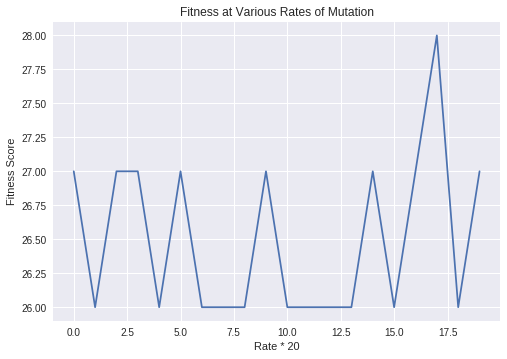

The maximum fitness score of 28.0 is obtained with mutation rate 0.8500000000000001.


In [32]:
def tune_rate(optimal_pop):
  rate = 0.01
  
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * 20

  for i in range(20):
    best_state, best_fitness = mlrose.genetic_alg(problem, pop_size=optimal_pop, mutation_prob=rate, max_attempts=10, max_iters=np.inf)
    
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = i * 0.05
      
    rate += 0.05

  plt.plot(fit_scores)

  plt.title("Fitness at Various Rates of Mutation")
  plt.xlabel("Rate * 20")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained with mutation rate ' + str(best_score_index) + '.')
  
  return best_score_index

optimal_rate = tune_rate(optimal_pop)

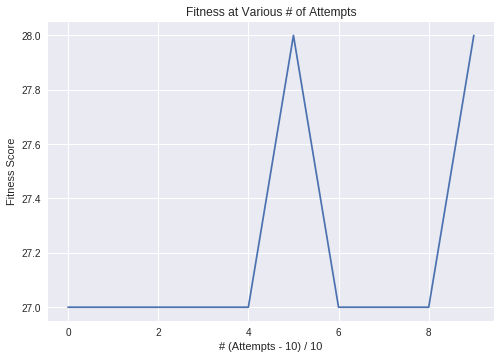

The maximum fitness score of 28.0 is obtained in 60 attempts.


In [33]:
def GA_tune_attempts(optimal_pop, optimal_rate):

  attempts = range(10, 110, 10)
  
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(attempts)

  for i, a in enumerate(attempts):
    best_state, best_fitness = mlrose.genetic_alg(problem, pop_size=optimal_pop, mutation_prob=optimal_rate, max_attempts=a, max_iters=np.inf)
    
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')
  
    fit_scores[i] = best_fitness

    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 10

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Attempts")
  plt.xlabel("# (Attempts - 10) / 10")
  plt.ylabel("Fitness Score")
  plt.show()

  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' attempts.')
  
  return best_score_index

optimal_attempt = GA_tune_attempts(optimal_pop, optimal_rate)

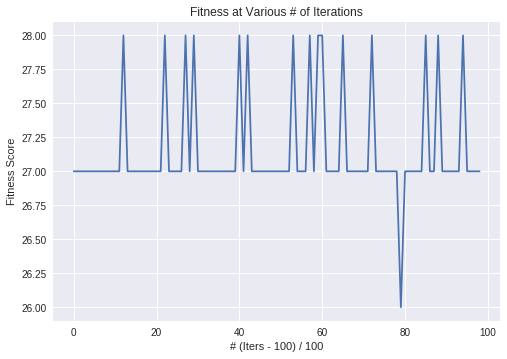

The maximum fitness score of 28.0 is obtained in 1300 iterations.


In [34]:
def GA_iters(optimal_pop, optimal_rate, optimal_attempt):
  best_score = 0
  best_score_index = -1
  
  iters = range(100, 10000, 100)
  
  fit_scores = [0] * len(iters)

  for i, a in enumerate(iters):
    best_state, best_fitness = mlrose.genetic_alg(problem, pop_size=optimal_pop, mutation_prob=optimal_rate, max_attempts=optimal_attempt, max_iters=a)

  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 100

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Iterations")
  plt.xlabel("# (Iters - 100) / 100")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' iterations.')
  
  return best_score_index, fit_scores

GA_best_iter, GA_fit_scores = GA_iters(optimal_pop, optimal_rate, optimal_attempt)

N:  8
The best state found is:  [2 6 5 3 0 4 7 1]
The fitness at the best state is:  27.0
The maximum fitness is:  28
The number of attacking queens is:  1


N:  9
The best state found is:  [2 5 3 8 0 8 4 1 7]
The fitness at the best state is:  35.0
The maximum fitness is:  36
The number of attacking queens is:  1


N:  10
The best state found is:  [2 6 3 0 8 5 9 6 1 4]
The fitness at the best state is:  43.0
The maximum fitness is:  45
The number of attacking queens is:  2


N:  11
The best state found is:  [7 5 3 8 0 5 3 9 6 4 1]
The fitness at the best state is:  52.0
The maximum fitness is:  55
The number of attacking queens is:  3


N:  12
The best state found is:  [ 2  7  6  8 11  0  6  3  5 10  8  1]
The fitness at the best state is:  62.0
The maximum fitness is:  66
The number of attacking queens is:  4


N:  13
The best state found is:  [ 9  7  2  0  6 10  5  2 11  1  3 12  8]
The fitness at the best state is:  75.0
The maximum fitness is:  78
The number of attacking queens is

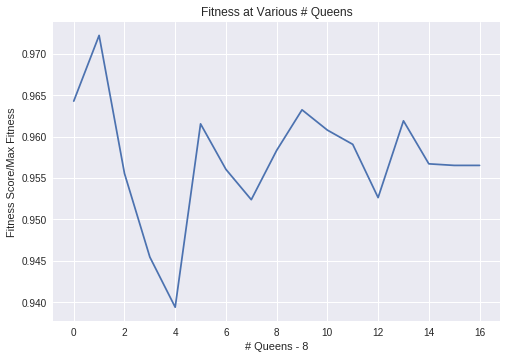

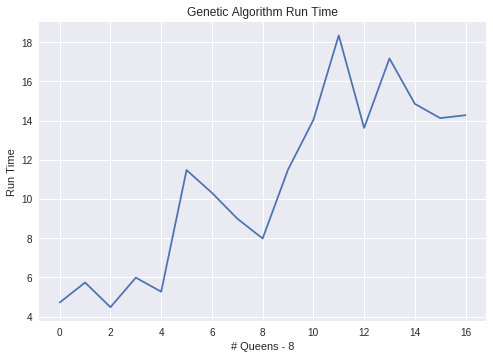

In [35]:
acc_GA_fit_scores = []
GA_times = []

for i in range(8, 25):
  problem = mlrose.DiscreteOpt(length = i, fitness_fn = fitness_cust,
                           maximize = True, max_val = i)
  
  # Define initial state
  init_state = np.array(np.arange(i))

  # Set random seed
  np.random.seed(i)
  
  start_time = timeit.default_timer()
  
  best_state, best_fitness = mlrose.genetic_alg(problem, pop_size=optimal_pop, mutation_prob=optimal_rate, max_attempts=optimal_attempt, max_iters=GA_best_iter)
  
  end_time = timeit.default_timer()
  training_time = end_time - start_time
  GA_times.append(training_time)

  print('N: ', str(i))
  print('The best state found is: ', best_state)
  print('The fitness at the best state is: ', best_fitness)
  print('The maximum fitness is: ', comb(i, 2, exact=True))
  print('The number of attacking queens is: ', int(comb(i, 2, exact=True) - best_fitness))
  print('\n')

  acc_GA_fit_scores.append(best_fitness / comb(i, 2, exact=True))

  
plt.plot(acc_GA_fit_scores)

plt.title("Fitness at Various # Queens")
plt.xlabel("# Queens - 8")
plt.ylabel("Fitness Score/Max Fitness")
plt.show()

plt.plot(GA_times)

plt.title("Genetic Algorithm Run Time")
plt.xlabel("# Queens - 8")
plt.ylabel("Run Time")
plt.show()

MIMIC
----------

In [0]:
problem = mlrose.DiscreteOpt(length = 8, fitness_fn = fitness_cust,
                         maximize = True, max_val = 8)

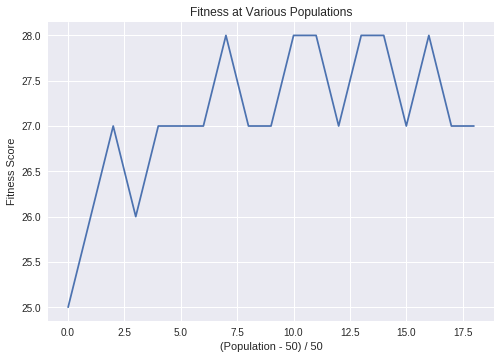

The maximum fitness score of 28.0 is obtained with population 400.


In [37]:
pop = range(50, 1000, 50)

def MIMIC_tune_pop(pop):
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(pop)

  for i, a in enumerate(pop):
    best_state, best_fitness = mlrose.mimic(problem, pop_size=a, keep_pct=0.2, max_attempts=10,
          max_iters=np.inf)
    
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 50

  plt.plot(fit_scores)

  plt.title("Fitness at Various Populations")
  plt.xlabel("(Population - 50) / 50")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained with population ' + str(best_score_index) + '.')
  
  return best_score_index

MIMIC_optimal_pop = MIMIC_tune_pop(pop)

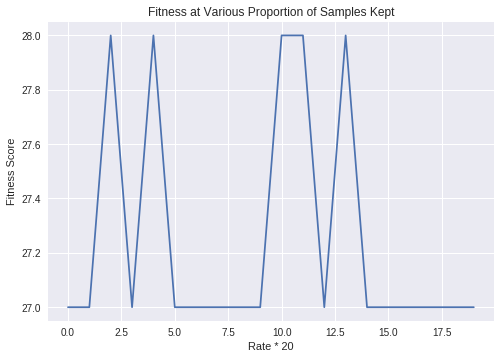

The maximum fitness score of 28.0 is obtained with 0.1 proportion samples kept.


In [38]:
def MIMIC_tune_rate(optimal_pop):
  rate = 0.01
  
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * 20

  for i in range(20):
    best_state, best_fitness = mlrose.mimic(problem, pop_size=optimal_pop, keep_pct=rate, max_attempts=10,
          max_iters=np.inf)
    
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = i * 0.05
      
    rate += 0.05

  plt.plot(fit_scores)

  plt.title("Fitness at Various Proportion of Samples Kept")
  plt.xlabel("Rate * 20")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained with ' + str(best_score_index) + ' proportion samples kept.')
  
  return best_score_index

MIMIC_optimal_rate = MIMIC_tune_rate(MIMIC_optimal_pop)

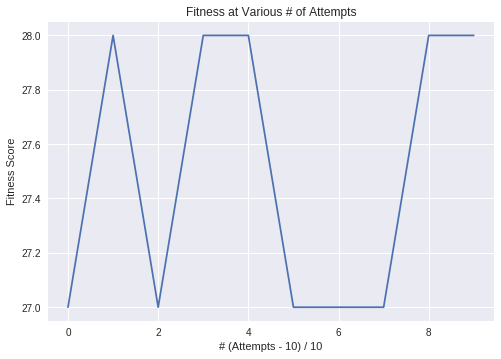

The maximum fitness score of 28.0 is obtained in 20 attempts.


In [39]:
def MIMIC_tune_attempts(optimal_pop, optimal_rate):

  attempts = range(10, 110, 10)
  
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(attempts)

  for i, a in enumerate(attempts):
    best_state, best_fitness = mlrose.mimic(problem, pop_size=optimal_pop, keep_pct=optimal_rate, max_attempts=a,
          max_iters=np.inf)  
    
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')
  
    fit_scores[i] = best_fitness

    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 10

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Attempts")
  plt.xlabel("# (Attempts - 10) / 10")
  plt.ylabel("Fitness Score")
  plt.show()

  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' attempts.')
  
  return best_score_index

MIMIC_optimal_attempt = MIMIC_tune_attempts(MIMIC_optimal_pop, MIMIC_optimal_rate)

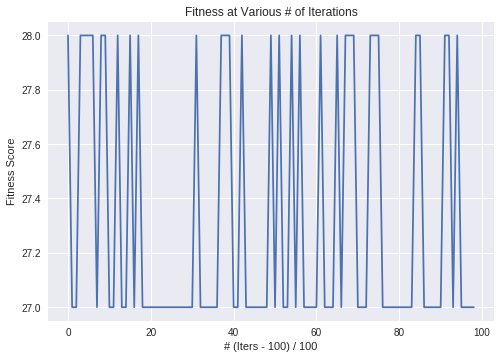

The maximum fitness score of 28.0 is obtained in 100 iterations.


In [40]:
def MIMIC_iters(optimal_pop, optimal_rate, optimal_attempt):
  best_score = 0
  best_score_index = -1
  
  iters = range(100, 10000, 100)
  
  fit_scores = [0] * len(iters)

  for i, a in enumerate(iters):
    best_state, best_fitness = mlrose.mimic(problem, pop_size=optimal_pop, keep_pct=optimal_rate, max_attempts=optimal_attempt,
          max_iters=a) 
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 100

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Iterations")
  plt.xlabel("# (Iters - 100) / 100")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' iterations.')
  
  return best_score_index, fit_scores

MIMIC_best_iter, MIMIC_fit_scores = MIMIC_iters(MIMIC_optimal_pop, MIMIC_optimal_rate, MIMIC_optimal_attempt)

N:  8
The best state found is:  [4 7 3 0 6 1 5 2]
The fitness at the best state is:  28.0
The maximum fitness is:  28
The number of attacking queens is:  0


N:  9
The best state found is:  [6 3 6 0 5 8 1 7 4]
The fitness at the best state is:  35.0
The maximum fitness is:  36
The number of attacking queens is:  1


N:  10
The best state found is:  [2 5 8 1 9 3 6 4 7 0]
The fitness at the best state is:  44.0
The maximum fitness is:  45
The number of attacking queens is:  1


N:  11
The best state found is:  [ 1  5  9  9  6  8  3 10  0  7  4]
The fitness at the best state is:  53.0
The maximum fitness is:  55
The number of attacking queens is:  2


N:  12
The best state found is:  [ 7  5  2  0  3 10  6  1 10  4 11  9]
The fitness at the best state is:  63.0
The maximum fitness is:  66
The number of attacking queens is:  3


N:  13
The best state found is:  [ 6  8  2  5 12  9  7  3 11  8 11  4 10]
The fitness at the best state is:  75.0
The maximum fitness is:  78
The number of attackin

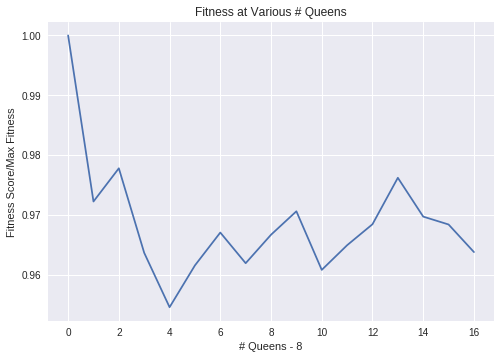

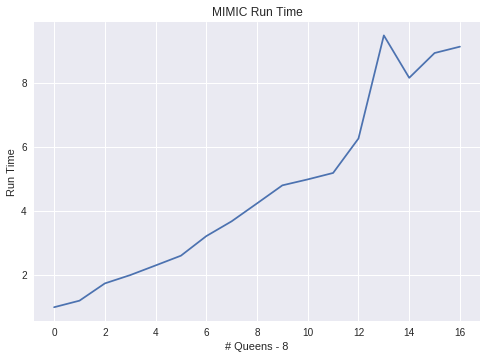

In [41]:
acc_MIMIC_fit_scores = []
MIMIC_times = []

for i in range(8, 25):
  problem = mlrose.DiscreteOpt(length = i, fitness_fn = fitness_cust,
                           maximize = True, max_val = i)
  
  # Define initial state
  init_state = np.array(np.arange(i))

  # Set random seed
  np.random.seed(i)
  
  start_time = timeit.default_timer()
  
  best_state, best_fitness = mlrose.mimic(problem, pop_size=MIMIC_optimal_pop, keep_pct=MIMIC_optimal_rate, max_attempts=MIMIC_optimal_attempt,
        max_iters=MIMIC_best_iter) 
  
  end_time = timeit.default_timer()
  training_time = end_time - start_time
  MIMIC_times.append(training_time)
  
  print('N: ', str(i))
  print('The best state found is: ', best_state)
  print('The fitness at the best state is: ', best_fitness)
  print('The maximum fitness is: ', comb(i, 2, exact=True))
  print('The number of attacking queens is: ', int(comb(i, 2, exact=True) - best_fitness))
  print('\n')

  acc_MIMIC_fit_scores.append(best_fitness / comb(i, 2, exact=True))

  
plt.plot(acc_MIMIC_fit_scores)

plt.title("Fitness at Various # Queens")
plt.xlabel("# Queens - 8")
plt.ylabel("Fitness Score/Max Fitness")
plt.show()

plt.plot(MIMIC_times)

plt.title("MIMIC Run Time")
plt.xlabel("# Queens - 8")
plt.ylabel("Run Time")
plt.show()

Randomized Hill Climbing
-----

In [0]:
problem = mlrose.DiscreteOpt(length = 8, fitness_fn = fitness_cust,
                         maximize = True, max_val = 8)

# Define initial state
init_state = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# Set random seed
np.random.seed(1)

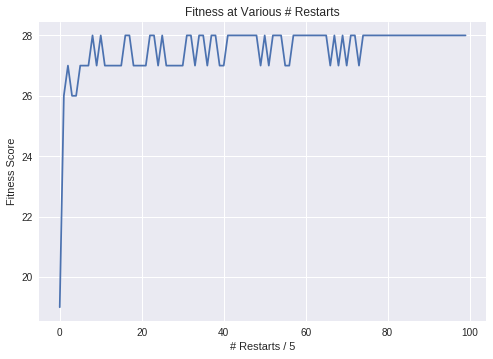

The maximum fitness score of 28.0 is obtained with 40 restarts.


In [43]:
restarts = range(0, 500, 5)

def tune_restarts(restarts):
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(restarts)

  for i, a in enumerate(restarts):
    best_state, best_fitness = mlrose.random_hill_climb(problem, max_attempts=10, max_iters=np.inf, restarts=a,
                      init_state=init_state)
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = i * 5

  plt.plot(fit_scores)

  plt.title("Fitness at Various # Restarts")
  plt.xlabel("# Restarts / 5")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained with ' + str(best_score_index) + ' restarts.')
  
  return best_score_index

optimal_restarts = tune_restarts(restarts)

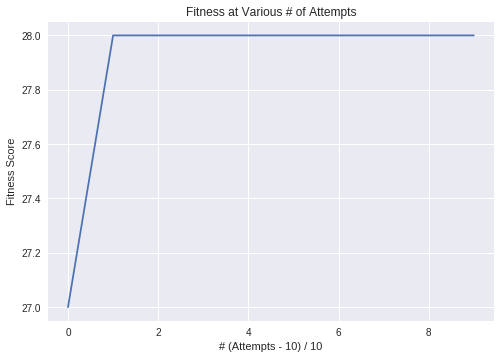

The maximum fitness score of 28.0 is obtained in 20 attempts.


In [44]:
def RHC_tune_attempts(optimal_restarts):

  attempts = range(10, 110, 10)
  
  best_score = 0
  best_score_index = -1
  
  fit_scores = [0] * len(attempts)

  for i, a in enumerate(attempts):
    best_state, best_fitness = mlrose.random_hill_climb(problem, max_attempts=a, max_iters=np.inf, restarts=optimal_restarts,
                      init_state=init_state)
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')
  
    fit_scores[i] = best_fitness

    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 10

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Attempts")
  plt.xlabel("# (Attempts - 10) / 10")
  plt.ylabel("Fitness Score")
  plt.show()

  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' attempts.')
  
  return best_score_index

RHC_optimal_attempt = RHC_tune_attempts(optimal_restarts)

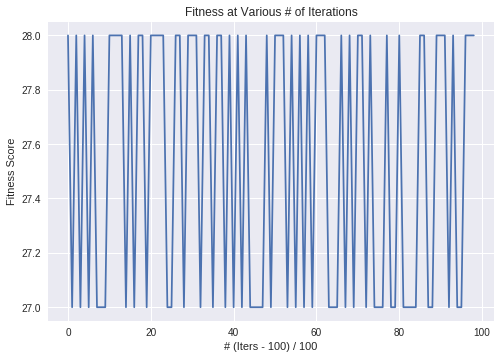

The maximum fitness score of 28.0 is obtained in 100 iterations.


In [45]:
def RHC_iters(optimal_restarts, optimal_attempt):
  best_score = 0
  best_score_index = -1
  
  iters = range(100, 10000, 100)
  
  fit_scores = [0] * len(iters)

  for i, a in enumerate(iters):
    best_state, best_fitness = mlrose.random_hill_climb(problem, max_attempts=optimal_attempt, max_iters=a, restarts=optimal_restarts,
                      init_state=init_state) 
  #   print('Iteration ', str(i))
  #   print('The best state found is: ', best_state)
  #   print('The fitness at the best state is: ', best_fitness)
  #   print('\n')

    fit_scores[i] = best_fitness
    
    if best_fitness > best_score:
      best_score = best_fitness
      best_score_index = (i + 1) * 100

  plt.plot(fit_scores)

  plt.title("Fitness at Various # of Iterations")
  plt.xlabel("# (Iters - 100) / 100")
  plt.ylabel("Fitness Score")
  plt.show()
  
  print('The maximum fitness score of ' + str(best_score) + ' is obtained in ' + str(best_score_index) + ' iterations.')
  
  return best_score_index, fit_scores

RHC_best_iter, RHC_fit_scores = RHC_iters(optimal_restarts, RHC_optimal_attempt)

N:  8
The best state found is:  [2 4 7 3 0 6 1 5]
The fitness at the best state is:  28.0
The maximum fitness is:  28
The number of attacking queens is:  0


N:  9
The best state found is:  [5 5 2 0 3 7 4 8 1]
The fitness at the best state is:  35.0
The maximum fitness is:  36
The number of attacking queens is:  1


N:  10
The best state found is:  [7 1 4 6 0 9 5 8 0 3]
The fitness at the best state is:  44.0
The maximum fitness is:  45
The number of attacking queens is:  1


N:  11
The best state found is:  [ 6  8  0  5  1 10  7  0  3  9  4]
The fitness at the best state is:  54.0
The maximum fitness is:  55
The number of attacking queens is:  1


N:  12
The best state found is:  [ 4  6 11  0  2  7  9  3  1  8 10  5]
The fitness at the best state is:  66.0
The maximum fitness is:  66
The number of attacking queens is:  0


N:  13
The best state found is:  [ 0 10 12  5  1 11  4  2  9  3  9  7  8]
The fitness at the best state is:  76.0
The maximum fitness is:  78
The number of attackin

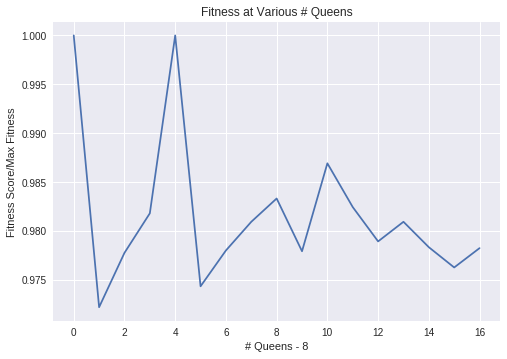

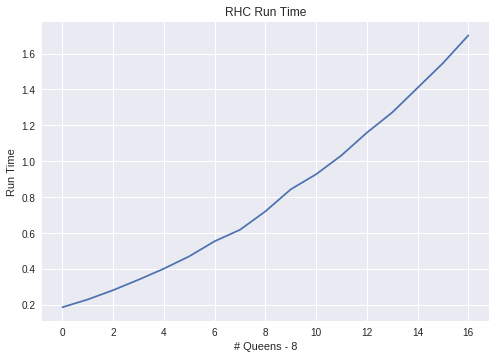

In [46]:
acc_RHC_fit_scores = []
RHC_times = []

for i in range(8, 25):
  problem = mlrose.DiscreteOpt(length = i, fitness_fn = fitness_cust,
                           maximize = True, max_val = i)
  
  # Define initial state
  init_state = np.array(np.arange(i))

  # Set random seed
  np.random.seed(i)
  
  start_time = timeit.default_timer()
  
  best_state, best_fitness = mlrose.random_hill_climb(problem, max_attempts=optimal_attempt, max_iters=RHC_best_iter, restarts=optimal_restarts,
                    init_state=init_state) 
  
  end_time = timeit.default_timer()
  training_time = end_time - start_time
  RHC_times.append(training_time)
  
  print('N: ', str(i))
  print('The best state found is: ', best_state)
  print('The fitness at the best state is: ', best_fitness)
  print('The maximum fitness is: ', comb(i, 2, exact=True))
  print('The number of attacking queens is: ', int(comb(i, 2, exact=True) - best_fitness))
  print('\n')

  acc_RHC_fit_scores.append(best_fitness / comb(i, 2, exact=True))

  
plt.plot(acc_RHC_fit_scores)

plt.title("Fitness at Various # Queens")
plt.xlabel("# Queens - 8")
plt.ylabel("Fitness Score/Max Fitness")
plt.show()

plt.plot(RHC_times)

plt.title("RHC Run Time")
plt.xlabel("# Queens - 8")
plt.ylabel("Run Time")
plt.show()

Technique Comparison Plots
------

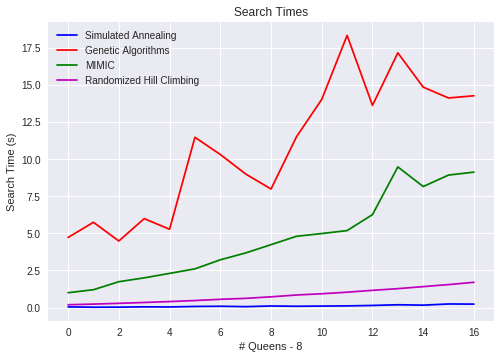

In [47]:
def compare_time(SA_times, GA_times, MIMIC_times, RHC_times):
    
    plt.figure()
    plt.title("Search Times")
    plt.xlabel("# Queens - 8")
    plt.ylabel("Search Time (s)")
    plt.plot(SA_times, '-', color="b", label="Simulated Annealing")
    plt.plot(GA_times, '-', color="r", label="Genetic Algorithms")
    plt.plot(MIMIC_times, '-', color="g", label="MIMIC")
    plt.plot(RHC_times, '-', color="m", label="Randomized Hill Climbing")
    plt.legend(loc="best")
    plt.show()
    
compare_time(SA_times, GA_times, MIMIC_times, RHC_times)

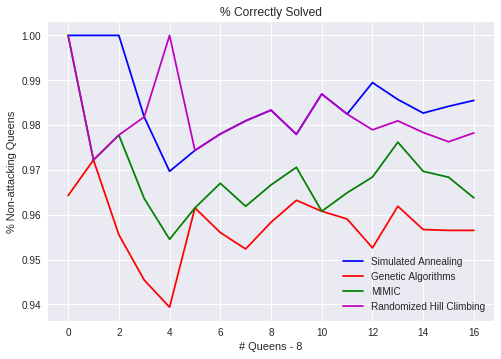

In [48]:
def compare_acc(SA_scores, GA_scores, MIMIC_scores, RHC_scores):
    
    plt.figure()
    plt.title("% Correctly Solved")
    plt.xlabel("# Queens - 8")
    plt.ylabel("% Non-attacking Queens")
    plt.plot(SA_scores, '-', color="b", label="Simulated Annealing")
    plt.plot(GA_scores, '-', color="r", label="Genetic Algorithms")
    plt.plot(MIMIC_scores, '-', color="g", label="MIMIC")
    plt.plot(RHC_scores, '-', color="m", label="Randomized Hill Climbing")
    plt.legend(loc="best")
    plt.show()
    
compare_acc(acc_SA_fit_scores, acc_GA_fit_scores, acc_MIMIC_fit_scores, acc_RHC_fit_scores)